# Forest Fire Prediction

## A project with an aim to optimize machine learning models in python

We will use a slightly modified dataset taken from [here](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)

### Exploring The Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
fires = pd.read_csv('fires.csv')

In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [4]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


### Reference Model

The reference model will only use temp and wind as features. The outcome of interest is the area column, which represents the total area damaged by the fire.

In [5]:
reference_fires = fires[["wind", "temp", "area"]].dropna()
reference_X = reference_fires[["wind", "temp"]]
reference_y = reference_fires[["area"]]
reference = LinearRegression()

### Data Processing

We will perform log-transformation of the "area" column.

<Axes: >

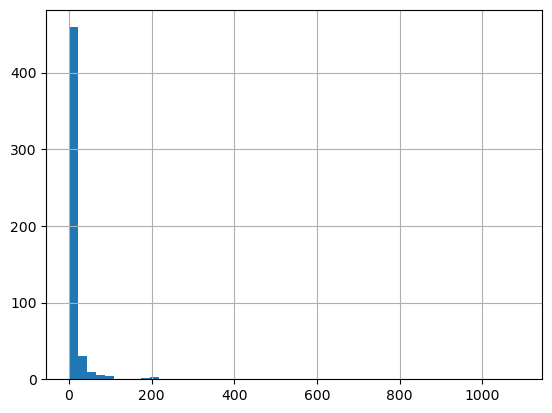

In [6]:
fires['area'].hist(bins=50)

In [7]:
fires['log_area'] = np.log(fires['area']+1)

<Axes: >

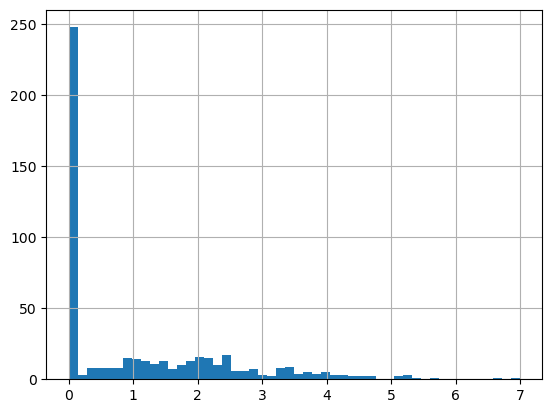

In [8]:
fires['log_area'].hist(bins=50)

We will change the column "month" for category column "summer"

In [9]:
summer_months = ['jun', 'jul', 'aug']
fires['summer'] = fires['month'].apply(lambda x: 1 if x in summer_months else 0)
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,summer
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0,0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0,0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0,0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0,0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0,0


Let´s convert day of the week into dummy variable

In [10]:
days = pd.get_dummies(fires['day'], drop_first=True)
days

,mon,sat,sun,thu,tue,wed
0,0,0,0,0,0,0
1,0,0,0,0,1,0
2,0,1,0,0,0,0
3,0,0,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
512,0,0,1,0,0,0
513,0,0,1,0,0,0
514,0,0,1,0,0,0
515,0,1,0,0,0,0


We will impute missing features with the help of K-nearest neighbors imputation.

In [11]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)
fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


Let´s examine outliers

<Axes: >

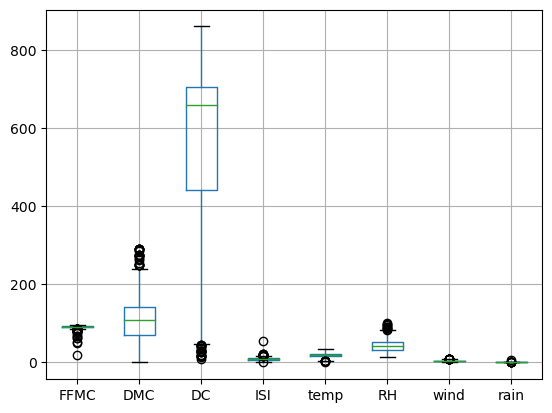

In [12]:
imputed.boxplot(column=list(imputed.columns))

Let's examine the number of outliers in each of the columns.

In [13]:
for col in imputed:
    quartiles = np.percentile(imputed[col], [25,50,75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))
    print(f"Number of outliers in the {col} is {num_outliers}")
    

Number of outliers in the FFMC is 53
Number of outliers in the DMC is 22
Number of outliers in the DC is 25
Number of outliers in the ISI is 23
Number of outliers in the temp is 9
Number of outliers in the RH is 10
Number of outliers in the wind is 13
Number of outliers in the rain is 8


We will leave outliers

Now we´ll standardize the dataset

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns=fires.columns[5:13])

final = pd.concat([fires['summer'], scaled, days], axis=1)
final.head()

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain,mon,sat,sun,thu,tue,wed
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268,0,0,0,0,0,0
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268,0,0,0,0,1,0
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268,0,1,0,0,0,0
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155,0,0,0,0,0,0
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268,0,0,1,0,0,0


### Subset Selection

In [15]:
y = fires['log_area']
final_and_y = pd.concat([final, y], axis=1)
corr = abs(final_and_y.corr())
corr

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain,mon,sat,sun,thu,tue,wed,log_area
summer,1.000000,0.214177,0.457106,0.159856,0.370985,0.419641,0.076650,0.019259,0.078261,0.125990,0.012047,0.062090,0.042282,0.060867,0.084696,0.048816
FFMC,0.214177,1.000000,0.377944,0.343971,0.527148,0.427011,0.305826,0.015168,0.056774,0.056237,0.019375,0.089677,0.069656,0.010301,0.094608,0.046767
DMC,0.457106,0.377944,1.000000,0.675980,0.304136,0.467701,0.085073,0.100278,0.075473,0.117232,0.002377,0.028175,0.090051,0.001951,0.018827,0.062982
DC,0.159856,0.343971,0.675980,1.000000,0.236874,0.500623,0.047074,0.199064,0.037378,0.055911,0.044676,0.011418,0.048853,0.027314,0.027794,0.064287
ISI,0.370985,0.527148,0.304136,0.236874,1.000000,0.392255,0.131033,0.107663,0.067796,0.158184,0.038064,0.002661,0.021967,0.069111,0.125905,0.009793
temp,0.419641,0.427011,0.467701,0.500623,0.392255,1.000000,0.507671,0.216221,0.069782,0.145573,0.033772,0.005675,0.051227,0.037087,0.094063,0.048333
RH,0.076650,0.305826,0.085073,0.047074,0.131033,0.507671,1.000000,0.061870,0.102162,0.015763,0.039929,0.136566,0.120909,0.010018,0.067824,0.043613
wind,0.019259,0.015168,0.100278,0.199064,0.107663,0.216221,0.061870,1.000000,0.061735,0.072275,0.059395,0.032628,0.045593,0.043152,0.019056,0.062179
rain,0.078261,0.056774,0.075473,0.037378,0.067796,0.069782,0.102162,0.061735,1.000000,0.029945,0.032271,0.017872,0.026798,0.139311,0.020744,0.023311
mon,0.125990,0.056237,0.117232,0.055911,0.158184,0.145573,0.015763,0.072275,0.029945,1.000000,0.180015,0.193919,0.149485,0.153623,0.139579,0.006160


<Axes: >

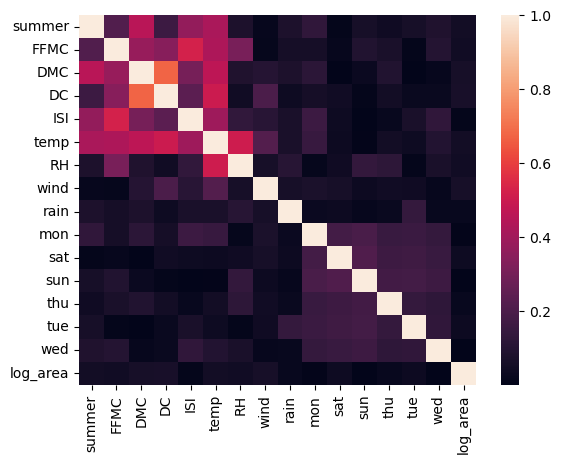

In [16]:
import seaborn as sns
sns.heatmap(corr)

'log_area' has very little correlation with all the columns. So for feature selection we will try SequentialFeatureSelector

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

forward_2 = SequentialFeatureSelector(estimator = model1,
                                      direction='forward',
                                      n_features_to_select=2)
forward_4 = SequentialFeatureSelector(estimator = model2,
                                      direction='forward',
                                      n_features_to_select=4)
forward_6 = SequentialFeatureSelector(estimator = model3,
                                      direction='forward',
                                      n_features_to_select=6)

forward_2.fit(final, y)
forward_4.fit(final, y)
forward_6.fit(final, y)

print(f"Features selected in 2 feature model:", forward_2.get_feature_names_out())
print(f"Features selected in 4 feature model:", forward_4.get_feature_names_out())
print(f"Features selected in 6 feature model:", forward_6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'wind' 'tue']
Features selected in 6 feature model: ['FFMC' 'DC' 'wind' 'sat' 'sun' 'tue']


In [18]:
backward_2 = SequentialFeatureSelector(estimator = model1,
                                      direction='backward',
                                      n_features_to_select=2)
backward_4 = SequentialFeatureSelector(estimator = model2,
                                      direction='backward',
                                      n_features_to_select=4)
backward_6 = SequentialFeatureSelector(estimator = model3,
                                      direction='backward',
                                      n_features_to_select=6)

backward_2.fit(final, y)
backward_4.fit(final, y)
backward_6.fit(final, y)

print(f"Features selected in 2 feature model:", backward_2.get_feature_names_out())
print(f"Features selected in 4 feature model:", backward_4.get_feature_names_out())
print(f"Features selected in 6 feature model:", backward_6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'tue']
Features selected in 4 feature model: ['FFMC' 'sat' 'sun' 'tue']
Features selected in 6 feature model: ['FFMC' 'DC' 'wind' 'sat' 'sun' 'tue']


So, according to feature selection, the best features are "FFMC", "DC", "tue" and "wind"

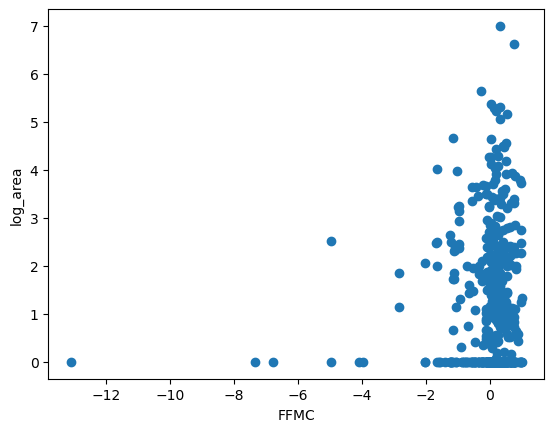

In [19]:
plt.scatter(final['FFMC'], y)
plt.xlabel('FFMC')
plt.ylabel('log_area')
plt.show()

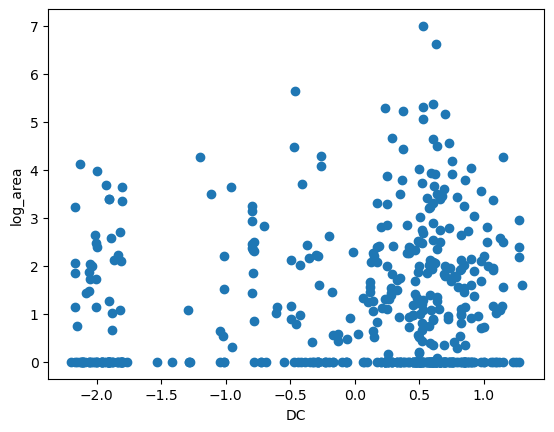

In [20]:
plt.scatter(final['DC'], y)
plt.xlabel('DC')
plt.ylabel('log_area')
plt.show()

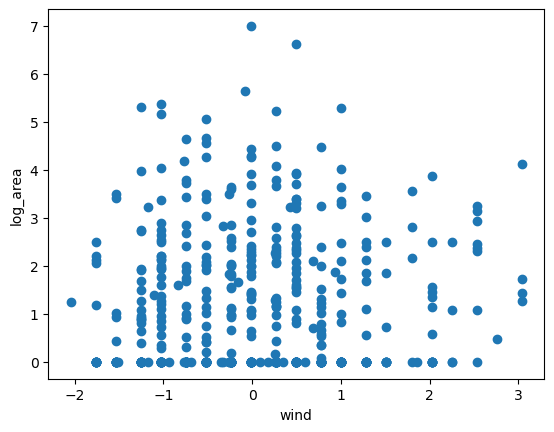

In [21]:
plt.scatter(final['wind'], y)
plt.xlabel('wind')
plt.ylabel('log_area')
plt.show()

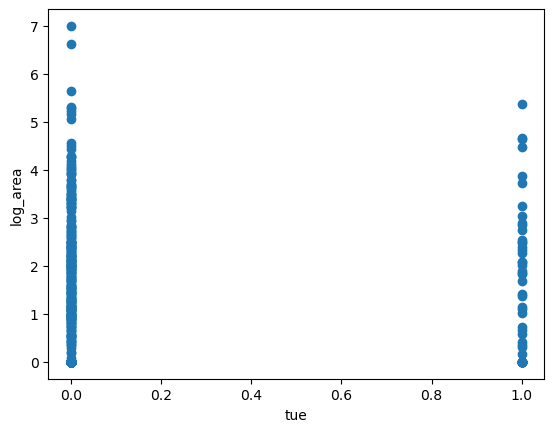

In [22]:
plt.scatter(final['tue'], y)
plt.xlabel('tue')
plt.ylabel('log_area')
plt.show()

In [23]:
fw2_model = LinearRegression()
fw4_model = LinearRegression()
fw6_model = LinearRegression()
bw2_model = LinearRegression()
bw4_model = LinearRegression()
bw6_model = LinearRegression()

### Regularized Models

We will try Lasso and Ridge models

In [24]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=100))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=100))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)


Ridge tuning parameter:  2728.0
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-7.16069204e-03  8.49322575e-03  1.23248699e-02  1.24927702e-02
 -4.78554171e-03  8.52667466e-03 -8.96780951e-03  1.48802281e-02
  4.87482521e-03 -2.95606147e-04  3.53231604e-03  5.53301968e-04
 -2.01610680e-03  2.66362715e-03 -2.02454169e-05]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.]


Lasso tuning parameter is on the extreme. And coeficients are zeros. it suggests that having no features at all is better than having any. 
We´ll continue with ridge model.

In [25]:
ridge = RidgeCV(alphas = np.linspace(2000, 3000, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)
print("Ridge coefficients: ", ridge.coef_)
print(final.columns)

Ridge tuning parameter:  2760.7607607607606
Ridge coefficients:  [-7.07166230e-03  8.42233283e-03  1.22131512e-02  1.23811754e-02
 -4.71564693e-03  8.45800604e-03 -8.88312186e-03  1.47220252e-02
  4.82853195e-03 -2.94216155e-04  3.49076644e-03  5.45869916e-04
 -1.99138560e-03  2.63330380e-03 -1.97504868e-05]
Index(['summer', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'mon', 'sat', 'sun', 'thu', 'tue', 'wed'],
      dtype='object')


### K-Fold Cross-Validation

We´ll compare different models we come to so long.

In [26]:
from sklearn.model_selection import cross_val_score

reference_cv = cross_val_score(reference, final[['wind', 'temp']], y, cv=5, scoring='neg_mean_absolute_error')
fw2_cv = cross_val_score(fw2_model, final[forward_2.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
fw4_cv = cross_val_score(fw4_model, final[forward_4.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
fw6_cv = cross_val_score(fw6_model, final[forward_6.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
bw2_cv = cross_val_score(bw2_model, final[backward_2.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
bw4_cv = cross_val_score(bw4_model, final[backward_4.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
bw6_cv = cross_val_score(bw6_model, final[backward_6.get_feature_names_out()], y, cv=5, scoring='neg_mean_absolute_error')
ridge_cv = cross_val_score(ridge, final, y, cv=5, scoring='neg_mean_absolute_error')                                

In [27]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(ridge_cv), " SD: ", np.std(ridge_cv))

Reference Model, Avg Test MSE:  -1.2284558766874276  SD:  0.2674337504305044
Forward-2 Model, Avg Test MSE:  -1.2215074601880649  SD:  0.2582089871381893
Forward-4 Model, Avg Test MSE:  -1.2204341036194635  SD:  0.2539836896563248
Forward-6 Model, Avg Test MSE:  -1.2245029937217142  SD:  0.2557789855233015
Backward-2 Model, Avg Test MSE:  -1.2217921640206133  SD:  0.25831370311882235
Backward-4 Model, Avg Test MSE:  -1.2249929003706277  SD:  0.2600315783713315
Backward-6 Model, Avg Test MSE:  -1.2245029937217142  SD:  0.2557789855233015
Ridge Model, Avg Test MSE:  -1.2255042526941538  SD:  0.2629426695905425


Forward selection model with 4 features is the best model, although none of the models performs well. Besides, we should remember that we use log-scale, so the predictions are off by a magnitude of about 2.

In [28]:
fw4_model.fit(final[forward_4.get_feature_names_out()], y)
y_predict = fw4_model.predict(final[forward_4.get_feature_names_out()])
y_predict = pd.Series(y_predict, name='predicted log_area')

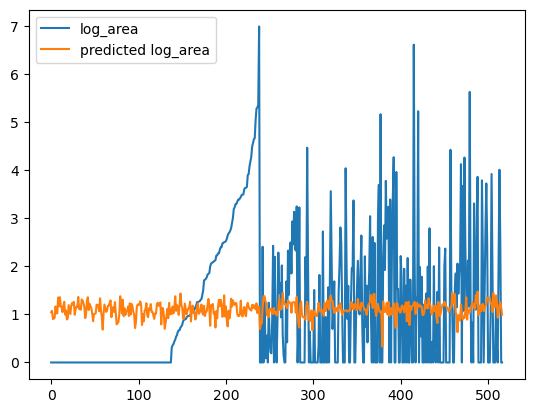

In [29]:
y.plot()
y_predict.plot()
plt.legend()
plt.show()

In [30]:
y_without_log = np.exp(y)-1
y_without_log.name = 'area'
prediction_without_log = np.exp(y_predict)-1
prediction_without_log.name = 'predicted area'

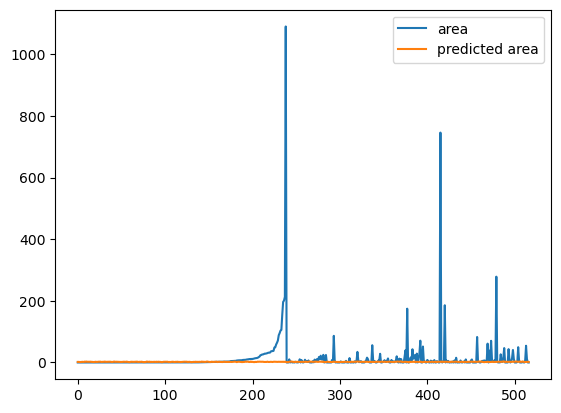

In [31]:
y_without_log.plot()
prediction_without_log.plot()
plt.legend()
plt.show()

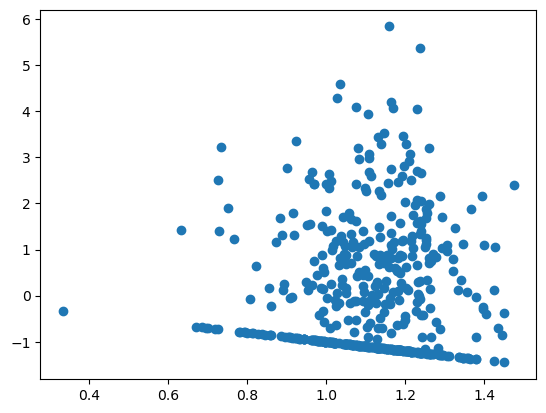

In [32]:
residuals = y - y_predict
plt.scatter(y_predict, residuals)
plt.show()

It´s a pity to say that our model predict very poorly. But seems that the problem here lies in the data available.